<a href="https://colab.research.google.com/github/LACDR-CDS/SCDR_RNAseq/blob/main/Session3and4/group2_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 3 & 4
In the last session, you learned the basic processing steps for RNA sequencing data. Now you will do the next steps in the analysis of transcriptomics data. First, you will figure out which genes are up- or downregulated between two conditions using differential gene expression analysis. Then you will link this to biological pathways with Gene Ontology enrichment.

# Background

iPSCs are valuable resource to model drug interactions with different tissue and are frequenly used in drug screens to gain insights into drug specificity and toxicity. Tyrosine kinase inhibitors (TKIs) are important drugs in cancer treatment. Unfortunately, certain TKIs may lead to cardiomyopathy as a severe side effect of these drugs.

Here, you will compare the transcriptomes of iPSC-derived cardiomyocites that were treated with two different FDA-approved TKIs, **Daunorubicin** and **Gefinitib**, for 48h to investigate their toxicity and gain insights into the biological pathways potentially leading to cardiotoxicity.

# Objectives

1. Explore the impact on global gene expression patterns (PCA).
2. Identify differentially expressed genes (DEGs) between drug treatment and control.
3. Visualized DEGs with volcano plots and heatmaps.
4. Perform GO enrichment to determine affected biological pathways.
5. Interpret the cardiotoxic potential of these drugs, and what cellular mechansims they might disrupt.


# Setup

Run the following cells to set up the necessary packages and download the data. If you wish to use a package which is not in the list below, you will need to install and import it yourself.


In [32]:
#Install packages which are not in the default environment
%pip install scanpy
%pip install pydeseq2
%pip install gseapy


In [33]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import pickle
import gseapy


In [34]:
group_number = 2


#Make data directory if it does not exist
os.makedirs("data", exist_ok=True)
os.makedirs("plots", exist_ok=True)

#Download datasets in the data folder
!wget https://raw.githubusercontent.com/LACDR-CDS/SCDR_Bioinformatics_Practical/refs/heads/main/Session3and4/data/counts_group{group_number}.txt -O data/group{group_number}.txt
!wget https://raw.githubusercontent.com/LACDR-CDS/SCDR_Bioinformatics_Practical/refs/heads/main/Session3and4/data/metadata_group{group_number}.txt -O data/group{group_number}_metadata.csv



--2025-12-12 13:37:43--  https://raw.githubusercontent.com/LACDR-CDS/SCDR_Bioinformatics_Practical/refs/heads/main/Session3and4/data/counts_group2.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2783683 (2.7M) [text/plain]
Saving to: ‘data/group2.txt’

data/group2.txt     100%[===================>]   2.65M  11.3MB/s    in 0.2s    

2025-12-12 13:37:44 (11.3 MB/s) - ‘data/group2.txt’ saved [2783683/2783683]

--2025-12-12 13:37:44--  https://raw.githubusercontent.com/LACDR-CDS/SCDR_Bioinformatics_Practical/refs/heads/main/Session3and4/data/metadata_group2.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.10

# Data import
Read in your counts and metadata table like you learned in session 2.
- How many samples do you have? Are there replicates?

In [35]:
count_table = pd.read_csv("data/group2.txt", sep="\t", index_col = 0)
count_table


,CTRL_1,CTRL_2,CTRL_3,CTRL_4,CTRL_5,CTRL_6,CTRL_7,CTRL_8,CTRL_9,CTRL_10,CTRL_11,CTRL_12,DAU_1,DAU_2,DAU_3,DAU_4,GEF_1,GEF_2,GEF_3,GEF_4
DDX11L1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
WASH7P,43,97,123,63,65,201,54,54,147,43,66,25,59,53,40,68,58,85,61,36
MIR6859-1,11,12,13,9,0,5,6,6,24,4,5,2,4,3,4,14,2,10,6,4
MIR1302-2HG,0,0,0,2,0,0,0,0,0,0,0,0,0,2,5,1,0,0,0,1
MIR1302-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ND6,28995,73551,81016,73372,45472,8313,54639,40297,107036,32030,132198,62151,42783,35278,26694,20024,32612,29949,136864,52715
TRNE,0,0,5,0,0,0,1,0,1,1,0,0,0,1,2,0,0,0,1,1
CYTB,110922,238506,251132,242836,146674,17113,143736,120934,337937,89561,359665,148701,128947,107883,85567,121308,115165,117685,306581,126033
TRNT,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
print(count_table.shape)

(42844, 20)


In [37]:
metadata_table = pd.read_csv("data/group2_metadata.csv", sep='\t', index_col = 0)
metadata_table

,treatment,Concentration,cell_line,cell_type,replicate
CTRL_1,Control,0nM,MSN05,cardiomyocytes,1
CTRL_2,Control,0nM,MSN05,cardiomyocytes,2
CTRL_3,Control,0nM,MSN05,cardiomyocytes,3
CTRL_4,Control,0nM,MSN05,cardiomyocytes,4
CTRL_5,Control,0nM,MSN05,cardiomyocytes,5
CTRL_6,Control,0nM,MSN05,cardiomyocytes,6
CTRL_7,Control,0nM,MSN05,cardiomyocytes,7
CTRL_8,Control,0nM,MSN05,cardiomyocytes,8
CTRL_9,Control,0nM,MSN05,cardiomyocytes,9
CTRL_10,Control,0nM,MSN05,cardiomyocytes,10


**Solution**  
- There are 20 samples and 3 conditions.
- There are 12 controls, and 4 replicates each per drug treatment (Daunorubicin and Gefinitib)

# Filtering

- How many genes do you have before and after filtering?

In [38]:
print("Genes before filtering:", count_table.shape[0])

Genes before filtering: 42844


In [39]:
gene_count_sums = count_table.sum(axis=1)
print(gene_count_sums)

DDX11L1              1
WASH7P            1441
MIR6859-1          144
MIR1302-2HG         11
MIR1302-2            0
                ...   
ND6            1115989
TRNE                13
CYTB           3316886
TRNT                 1
TRNP             28648
Length: 42844, dtype: int64


In [40]:
filtered_count_table= count_table[gene_count_sums >= 10]
filtered_count_table

,CTRL_1,CTRL_2,CTRL_3,CTRL_4,CTRL_5,CTRL_6,CTRL_7,CTRL_8,CTRL_9,CTRL_10,CTRL_11,CTRL_12,DAU_1,DAU_2,DAU_3,DAU_4,GEF_1,GEF_2,GEF_3,GEF_4
WASH7P,43,97,123,63,65,201,54,54,147,43,66,25,59,53,40,68,58,85,61,36
MIR6859-1,11,12,13,9,0,5,6,6,24,4,5,2,4,3,4,14,2,10,6,4
MIR1302-2HG,0,0,0,2,0,0,0,0,0,0,0,0,0,2,5,1,0,0,0,1
LOC124900384,7,6,5,7,3,11,7,9,8,4,9,1,0,0,3,5,3,8,1,1
LOC729737,280,637,868,525,320,267,356,444,809,409,494,220,43,27,147,107,245,384,343,144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ND5,95020,214077,226461,167502,96451,43617,145906,110865,265046,84772,325879,150296,99145,80859,73904,66932,98513,90866,302952,101419
ND6,28995,73551,81016,73372,45472,8313,54639,40297,107036,32030,132198,62151,42783,35278,26694,20024,32612,29949,136864,52715
TRNE,0,0,5,0,0,0,1,0,1,1,0,0,0,1,2,0,0,0,1,1
CYTB,110922,238506,251132,242836,146674,17113,143736,120934,337937,89561,359665,148701,128947,107883,85567,121308,115165,117685,306581,126033


In [41]:
print("Genes after filtering:", filtered_count_table.shape[0])

Genes after filtering: 30365


**Solution**  
- There are 42844 genes before filtering and 30365 after.

# Normalization: counts per million
Perform normalization to account for differences in sequencing depth among samples.

In [42]:
total_reads = filtered_count_table.sum(axis = 0)
normalized_count_table = (filtered_count_table /  total_reads) * 1000000
log_transformed_counts = np.log2(normalized_count_table + 1)

# Principle component analysis (PCA)

Now explore your data with PCA like you did in the previous session.
- Which drug do you think has a stronger effect on gene expression based on the clustering pattern?
- How do you expect the size of the effect to impact gene expression profiles? Do you expect a difference in up- or downregulated genes?

In [43]:
scaler = StandardScaler()

scaled_table = scaler.fit_transform(log_transformed_counts.T)

pca = PCA()

pca_result_matrix= pca.fit_transform(scaled_table)



In [44]:
np.shape(pca_result_matrix)

(20, 20)

In [45]:
plot_df = pd.DataFrame({

 "PC1": pca_result_matrix[:, 0],

 "PC2": pca_result_matrix[:, 1],

 "condition": metadata_table["treatment"].values
 })

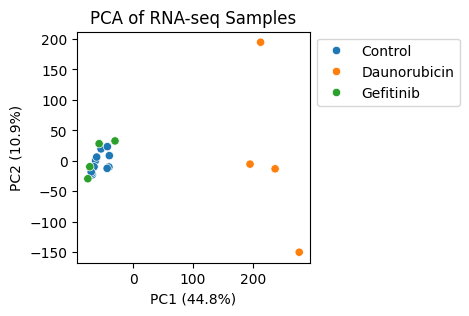

In [46]:
plt.figure(figsize=(3, 3))
sns.scatterplot(

data=plot_df,

x="PC1", y="PC2",

hue="condition"

)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of RNA-seq Samples")
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig("plots/PCA_session2.png", dpi = 200)

plt.show()

# Differential gene expression

Now you can perform differential gene expression analysis using the DEseq2 method. This method allows to find genes with significant expression differences (up- or downregulated) bewteen two conditions.
- Your goal is to investigate the effect of the drugs on cardiomyocyte differentiation. Which samples do you need to compare?
- Then, build you DEseq object(s) and run the analysis. *Make sure you use the raw counts for this (not the counts per million normalized counts used for PCA), since DEseq does it's own internal normalization method.*
- Analyse the output of your DEseq analysis. Does the number of differentially expressed genes match your expectiations from the PCA analysis?
- Look up the most up/downregulated genes between the conditions. Visualise the first 10 in a volcano plot or heatmap. Can you draw any conclusion from this about the drug effect?

**Solution**  
- We want to compare each drug with the control. Therefore, we need to do two seperate DE analysis, once Daunorubicin vs Ctrl and then Gefinitib vs Ctrl.


In [47]:
drug = "Daunorubicin"

metadata_df_filtered_dau = metadata_table[metadata_table["treatment"].isin([drug, "Control"])]
counts_filtered_dau = filtered_count_table[metadata_df_filtered_dau.index]

# Create DESeq2 object
deseq_object = DeseqDataSet(
    counts=counts_filtered_dau.T,
    metadata=metadata_df_filtered_dau,
    design_factors="treatment",
)

# Run DESeq2
deseq_object.deseq2()

# Get results for the current contrast
stat_res_dau = DeseqStats(
    deseq_object, contrast=("treatment", "Daunorubicin", "Control")
)
stat_res_dau.summary()
results_df_dau = stat_res_dau.results_df


/tmp/ipython-input-3674783047.py:7: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  deseq_object = DeseqDataSet(
Fitting size factors...
... done in 0.04 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 42.02 seconds.

Fitting dispersion trend curve...
... done in 0.97 seconds.

Fitting MAP dispersions...
... done in 51.00 seconds.

Fitting LFCs...
... done in 27.87 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 144 outlier genes.

Fitting dispersions...
... done in 0.24 seconds.

Fitting MAP dispersions...
... done in 0.25 seconds.

Fitting LFCs...
... done in 0.18 seconds.

Running Wald tests...
... done in 9.31 seconds.



Log2 fold change & Wald test p-value: treatment Daunorubicin vs Control
                   baseMean  log2FoldChange     lfcSE      stat        pvalue  \
WASH7P            66.706666       -0.001252  0.265227 -0.004721  9.962335e-01   
MIR6859-1          6.980494        0.264302  0.608161  0.434592  6.638589e-01   
MIR1302-2HG        0.691158        3.374893  2.055614  1.641793  1.006329e-01   
LOC124900384       5.024932       -1.174227  0.711945 -1.649322  9.908168e-02   
LOC729737        337.828353       -2.020399  0.370436 -5.454104  4.922033e-08   
...                     ...             ...       ...       ...           ...   
ND5           133449.488643       -0.611367  0.351347 -1.740066  8.184737e-02   
ND6            51316.290599       -0.620958  0.417712 -1.486570  1.371285e-01   
TRNE               0.618895        0.705023  1.861495  0.378740  7.048810e-01   
CYTB          156937.266320       -0.294155  0.420639 -0.699305  4.843614e-01   
TRNP            1459.099525        1.

In [48]:
# Get upregulated and downregulated genes
upregulated_genes_dau = results_df_dau[
    (results_df_dau["log2FoldChange"] > 2) & (results_df_dau["padj"] < 0.05)
]
downregulated_genes_dau = results_df_dau[
    (results_df_dau["log2FoldChange"] < -2) & (results_df_dau["padj"] < 0.05)
]
print(f"    Upregulated genes: {upregulated_genes_dau.shape[0]}")
print(f"    Downregulated genes: {downregulated_genes_dau.shape[0]}")



    Upregulated genes: 6838
    Downregulated genes: 1088


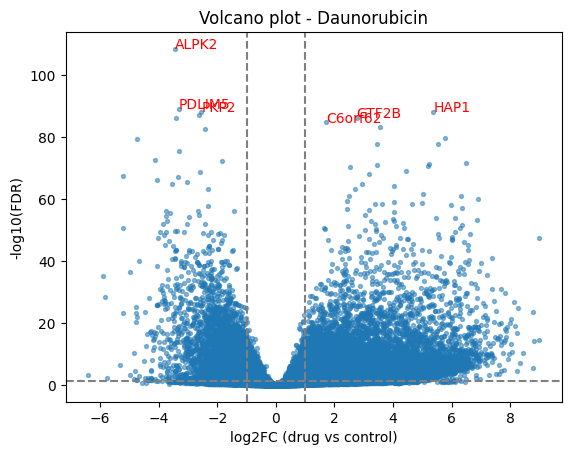

In [49]:
plt.scatter(
    results_df_dau.log2FoldChange, -np.log10(results_df_dau.padj), s=8, alpha=0.5
)
plt.axhline(-np.log10(0.05), ls="--", color="grey")
plt.axvline(1, ls="--", color="grey")
plt.axvline(-1, ls="--", color="grey")
plt.xlabel("log2FC (drug vs control)")
plt.ylabel("-log10(FDR)")
plt.title(f"Volcano plot - {drug}")

up = results_df_dau[results_df_dau.log2FoldChange > 1].nsmallest(3, "padj")
down = results_df_dau[results_df_dau.log2FoldChange < -1].nsmallest(3, "padj")

for gene, r in up.iterrows():
  plt.text(r.log2FoldChange, -np.log10(r.padj), gene,
  fontsize=10, color="red")
for gene, r in down.iterrows():
  plt.text(r.log2FoldChange, -np.log10(r.padj), gene,
  fontsize=10, color="red")

plt.show()



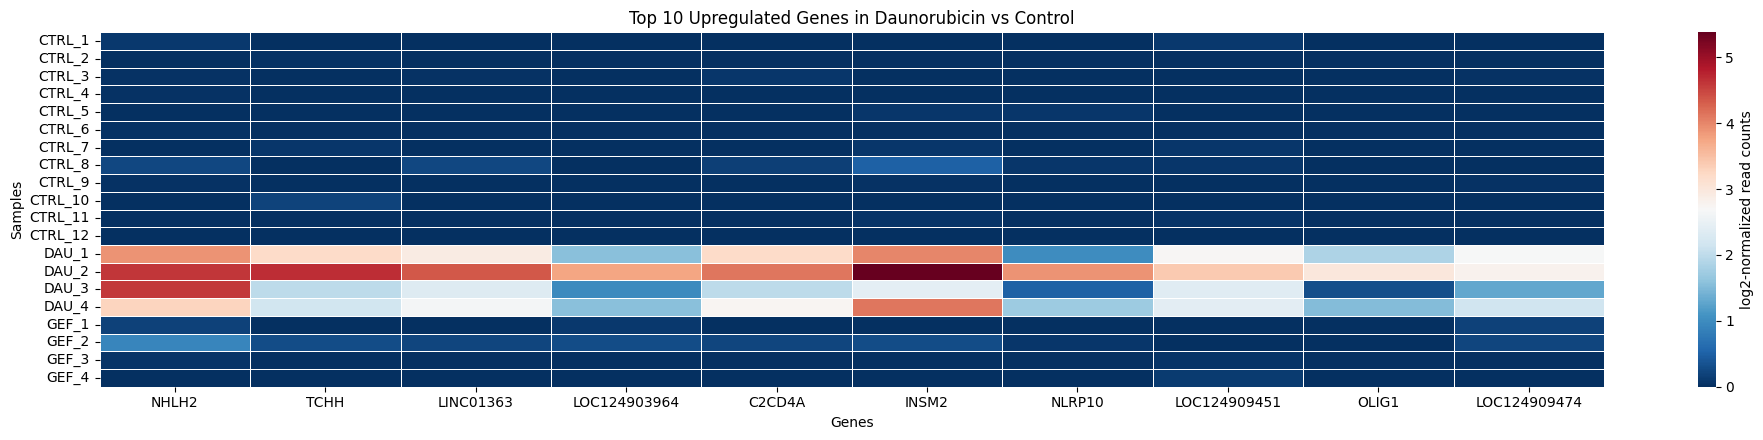

In [50]:
gene_list = upregulated_genes_dau.sort_values(by="log2FoldChange", ascending=False).head(10).index


subset = log_transformed_counts.loc[log_transformed_counts.index.intersection(gene_list)].T
subset = subset[gene_list]

plt.figure(figsize=(len(subset), 4.5))

sns.heatmap(subset, cmap="RdBu_r", linecolor = "white", linewidth = 0.5, cbar_kws={"label": "log2-normalized read counts"}
)
plt.title("Top 10 Upregulated Genes in Daunorubicin vs Control")
plt.xlabel("Genes")
plt.ylabel("Samples")
plt.tight_layout()
plt.savefig("plots/heatmap_session2.png", dpi = 200)
plt.show()

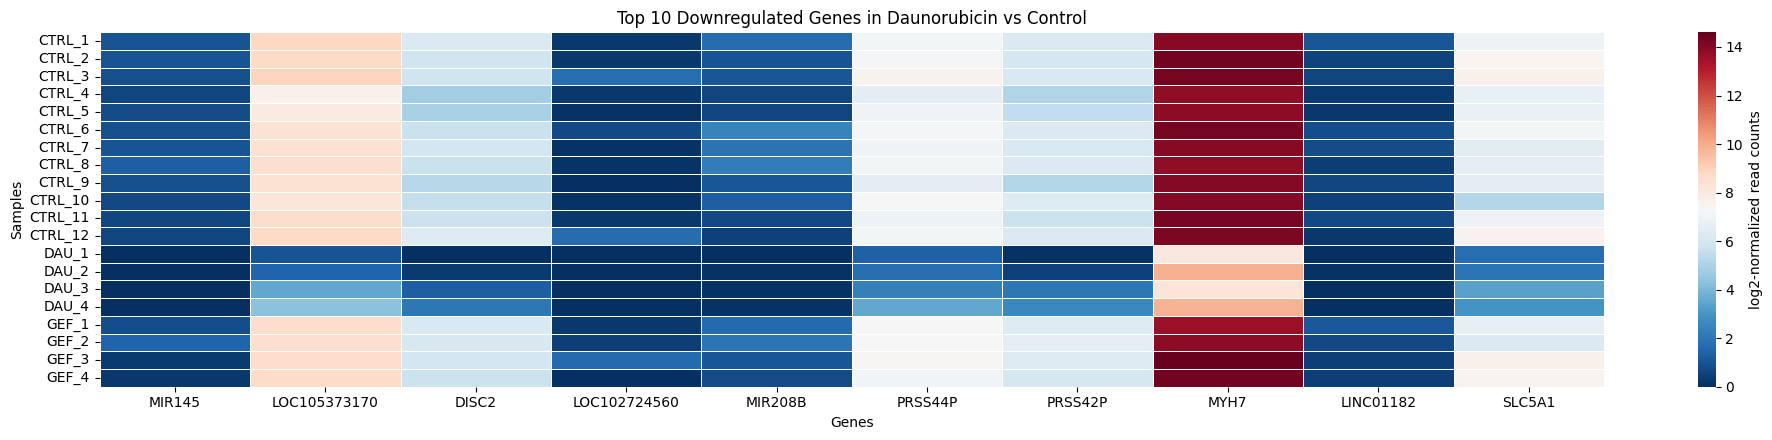

In [51]:
gene_list = downregulated_genes_dau.sort_values(by="log2FoldChange", ascending=True).head(10).index

subset = log_transformed_counts.loc[log_transformed_counts.index.intersection(gene_list)].T
subset = subset[gene_list]

plt.figure(figsize=(len(subset), 4.5))

sns.heatmap(subset, cmap="RdBu_r", linecolor = "white", linewidth = 0.5, cbar_kws={"label": "log2-normalized read counts"}
)
plt.title("Top 10 Downregulated Genes in Daunorubicin vs Control")
plt.xlabel("Genes")
plt.ylabel("Samples")
plt.tight_layout()
plt.savefig("plots/heatmap_session2.png", dpi = 200)
plt.show()

**Solution**  
Now repeat the analysis for Gefinitib





In [52]:
drug = "Gefitinib"

metadata_df_filtered_gef = metadata_table[metadata_table["treatment"].isin([drug, "Control"])]
counts_filtered_gef = filtered_count_table[metadata_df_filtered_gef.index]

# Create DESeq2 object
deseq_object = DeseqDataSet(
    counts=counts_filtered_gef.T,
    metadata=metadata_df_filtered_gef,
    design_factors="treatment",
)

# Run DESeq2
deseq_object.deseq2()

# Get results for the current contrast
stat_res_gef = DeseqStats(deseq_object, contrast=("treatment", "Gefitinib", "Control"))
stat_res_gef.summary()
results_df_gef = stat_res_gef.results_df




/tmp/ipython-input-1942930641.py:7: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  deseq_object = DeseqDataSet(
Fitting size factors...
... done in 0.04 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 39.10 seconds.

Fitting dispersion trend curve...
... done in 1.23 seconds.

Fitting MAP dispersions...
... done in 49.92 seconds.

Fitting LFCs...
... done in 28.17 seconds.

Calculating cook's distance...
... done in 0.06 seconds.

Replacing 184 outlier genes.

Fitting dispersions...
... done in 0.48 seconds.

Fitting MAP dispersions...
... done in 0.53 seconds.

Fitting LFCs...
... done in 0.50 seconds.

Running Wald tests...
... done in 7.97 seconds.



Log2 fold change & Wald test p-value: treatment Gefitinib vs Control
                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
WASH7P            67.989688        0.209971  0.244142  0.860035  0.389770   
MIR6859-1          6.570236        0.087230  0.557119  0.156573  0.875581   
MIR1302-2HG        0.205009        0.774081  3.684159  0.210111  0.833581   
LOC124900384       5.252381       -0.453287  0.598101 -0.757876  0.448525   
LOC729737        392.398424       -0.240469  0.246145 -0.976941  0.328599   
...                     ...             ...       ...       ...       ...   
ND5           153381.449154        0.362097  0.373781  0.968741  0.332674   
ND6            61270.934214        0.531070  0.514661  1.031884  0.302126   
TRNE               0.576040        0.264515  1.870689  0.141400  0.887554   
CYTB          173670.016579        0.382910  0.425452  0.900008  0.368116   
TRNP            1076.775011        0.281788  0.348530  0.808504  0.418800   

      

In [53]:
# Get upregulated and downregulated genes
upregulated_genes_gef = results_df_gef[
    (results_df_gef["log2FoldChange"] > 2) & (results_df_gef["padj"] < 0.05)
]
downregulated_genes_gef = results_df_gef[
    (results_df_gef["log2FoldChange"] < -2) & (results_df_gef["padj"] < 0.05)
]
print(f"    Upregulated genes: {upregulated_genes_gef.shape[0]}")
print(f"    Downregulated genes: {downregulated_genes_gef.shape[0]}")



    Upregulated genes: 0
    Downregulated genes: 11


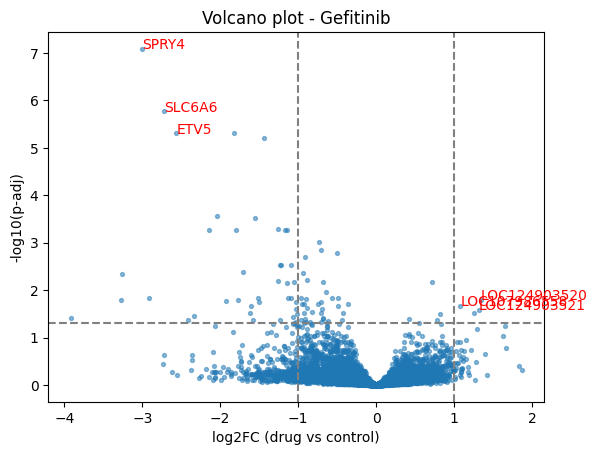

In [54]:
plt.scatter(
    results_df_gef.log2FoldChange, -np.log10(results_df_gef.padj), s=8, alpha=0.5
)
plt.axhline(-np.log10(0.05), ls="--", color="grey")
plt.axvline(1, ls="--", color="grey")
plt.axvline(-1, ls="--", color="grey")
plt.xlabel("log2FC (drug vs control)")
plt.ylabel("-log10(p-adj)")
plt.title(f"Volcano plot - {drug}")


up = results_df_gef[results_df_gef.log2FoldChange > 1].nsmallest(3, "padj")
down = results_df_gef[results_df_gef.log2FoldChange < -1].nsmallest(3, "padj")

for gene, r in up.iterrows():
  plt.text(r.log2FoldChange, -np.log10(r.padj), gene,
  fontsize=10, color="red")
for gene, r in down.iterrows():
  plt.text(r.log2FoldChange, -np.log10(r.padj), gene,
  fontsize=10, color="red")

plt.show()



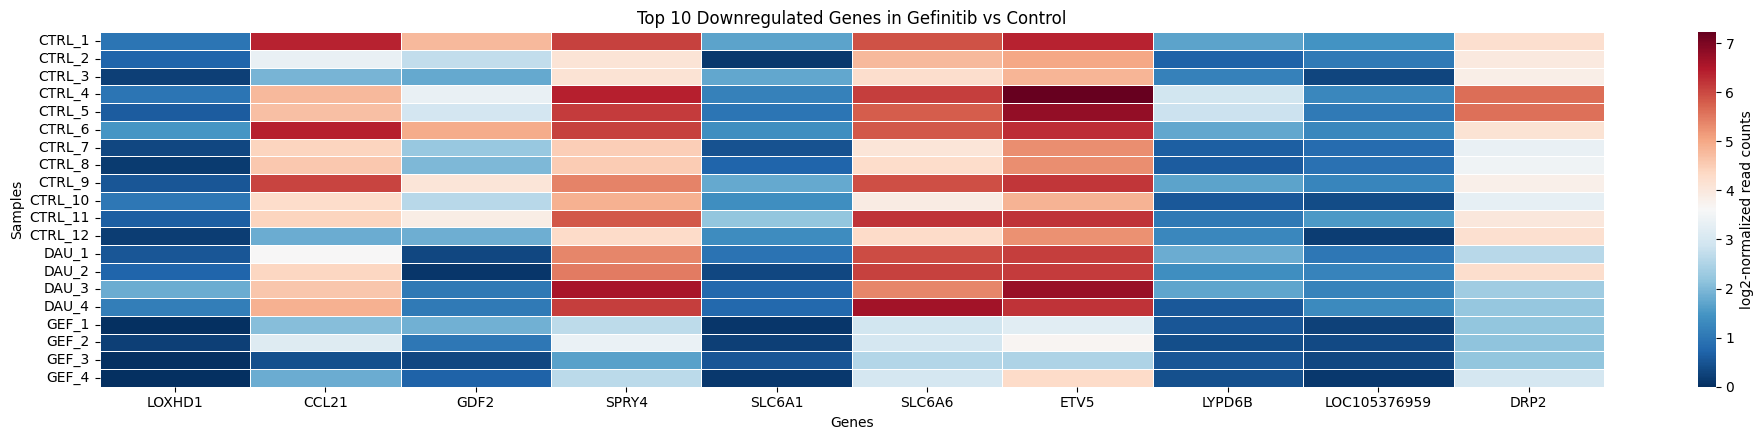

In [55]:
gene_list = downregulated_genes_gef.sort_values(by="log2FoldChange", ascending=True).head(10).index

subset = log_transformed_counts.loc[log_transformed_counts.index.intersection(gene_list)].T
subset = subset[gene_list]

plt.figure(figsize=(len(subset), 4.5))

sns.heatmap(subset, cmap="RdBu_r", linecolor = "white", linewidth = 0.5, cbar_kws={"label": "log2-normalized read counts"}
)
plt.title("Top 10 Downregulated Genes in Gefinitib vs Control")
plt.xlabel("Genes")
plt.ylabel("Samples")
plt.tight_layout()
plt.savefig("plots/heatmap_session2.png", dpi = 200)
plt.show()

In [61]:
subset

,LOXHD1,CCL21,GDF2,SPRY4,SLC6A1,SLC6A6,ETV5,LYPD6B,LOC105376959,DRP2
CTRL_1,0.973924,6.379486,4.772627,6.068376,1.664208,5.911123,6.376350,1.691381,1.458155,4.202843
CTRL_2,0.709934,3.348966,2.730069,4.102843,0.119941,4.773674,5.008077,0.684220,1.069069,3.976122
CTRL_3,0.223784,1.935274,1.755768,4.122316,1.731674,4.240151,4.832384,1.157353,0.291277,3.861485
CTRL_4,0.964756,4.767053,3.335919,6.411366,1.158114,6.099570,7.219115,2.911149,1.245870,5.625576
CTRL_5,0.619484,4.703014,2.935543,6.119823,0.974813,5.788587,6.777595,2.830685,1.051478,5.592467
CTRL_6,1.487570,6.421926,4.951574,6.082234,1.372250,5.865482,6.283658,1.741022,1.246905,4.132056
CTRL_7,0.317079,4.409690,2.243745,4.497086,0.478495,4.064502,5.298135,0.623654,0.837200,3.328500
CTRL_8,0.161395,4.586320,1.985210,4.535681,0.723362,4.278449,5.276475,0.616034,0.916676,3.459707
CTRL_9,0.535006,6.057981,4.074662,5.394686,1.757611,5.943217,6.177185,1.680640,1.218673,3.831291
CTRL_10,1.008526,4.264040,2.617559,4.882037,1.354283,3.900380,4.855130,0.552879,0.391042,3.280588


**Solution**  
- There are many DE genes for Daunorubicin, but only 11 DE genes for Gefinitib. Therefore, we would predict that Daunorubicin is more toxic to cardiomyocites.
- The few genes that show as up/downregualted for Gefinitib are likely an artifact, since the still are more similarly expressed to control compared to Epirubicin treatment.


# Gene Ontology enrichment

Now, you can start interpreting the lists of genes you get from the DEseq analysis and learn if there are any biological pathways that are effected by the drug treatment.
- Use the cheat sheet to perform a GO enrichment analysis on the upregulated and dowregulated genes from your DEseq analysis. Which pathways can you see?
- Based on this analysis, do you think either of the drugs you tested are cardiotoxic? Which cellular mechanisms do they disrupt?

In [62]:


GO_databases = [
    "GO_Biological_Process_2025",
    "GO_Cellular_Component_2025",
    "GO_Molecular_Function_2025",
]



In [64]:
import time

go_upr_results_dau = {}
go_dwr_results_dau = {}

for db in GO_databases:
    try:
        print(f"    {db}")

        # Upregulated genes
        enr_upr = gseapy.enrichr(
            gene_list=upregulated_genes_dau.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_upr_results_dau[db] = enr_upr.res2d

        # Downregulated genes
        enr_dwr = gseapy.enrichr(
            gene_list=downregulated_genes_dau.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_dwr_results_dau[db] = enr_dwr.res2d

    except Exception as e:
        time.sleep(30)  # Wait longer if there's an error



    GO_Biological_Process_2025
    GO_Cellular_Component_2025
    GO_Molecular_Function_2025


In [65]:


print(go_upr_results_dau)
print(go_dwr_results_dau)



{'GO_Biological_Process_2025':                         Gene_set  \
0     GO_Biological_Process_2025   
1     GO_Biological_Process_2025   
2     GO_Biological_Process_2025   
3     GO_Biological_Process_2025   
4     GO_Biological_Process_2025   
...                          ...   
4167  GO_Biological_Process_2025   
4168  GO_Biological_Process_2025   
4169  GO_Biological_Process_2025   
4170  GO_Biological_Process_2025   
4171  GO_Biological_Process_2025   

                                                   Term Overlap   P-value  \
0     Protection From Natural Killer Cell Mediated C...     5/5  0.004667   
1                   Neuron Fate Commitment (GO:0048663)   11/16  0.005035   
2     Regulation of Natural Killer Cell Activation (...   11/16  0.005035   
3                Response to Interleukin-4 (GO:0070670)     7/9  0.009670   
4     Positive Regulation of Animal Organ Morphogene...     5/6  0.020029   
...                                                 ...     ...       ... 

In [66]:


for k, v in go_upr_results_dau.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k[0], k[1]} \n {k[2]} \n Upregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                # top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")



GO_Biological_Process_2025: (4172, 10)
Error occurred while plotting GO_Biological_Process_2025: Warning: No enrich terms when cutoff = 0.05
GO_Cellular_Component_2025: (340, 10)
Error occurred while plotting GO_Cellular_Component_2025: Warning: No enrich terms when cutoff = 0.05
GO_Molecular_Function_2025: (874, 10)
Error occurred while plotting GO_Molecular_Function_2025: Warning: No enrich terms when cutoff = 0.05


GO_Biological_Process_2025: (2751, 10)
GO_Cellular_Component_2025: (230, 10)
GO_Molecular_Function_2025: (545, 10)


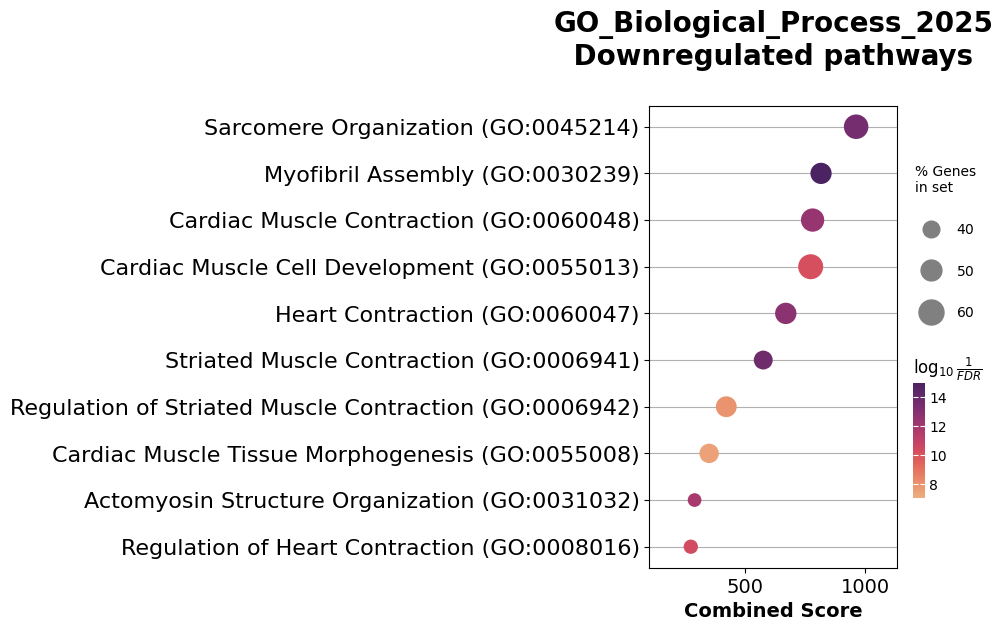

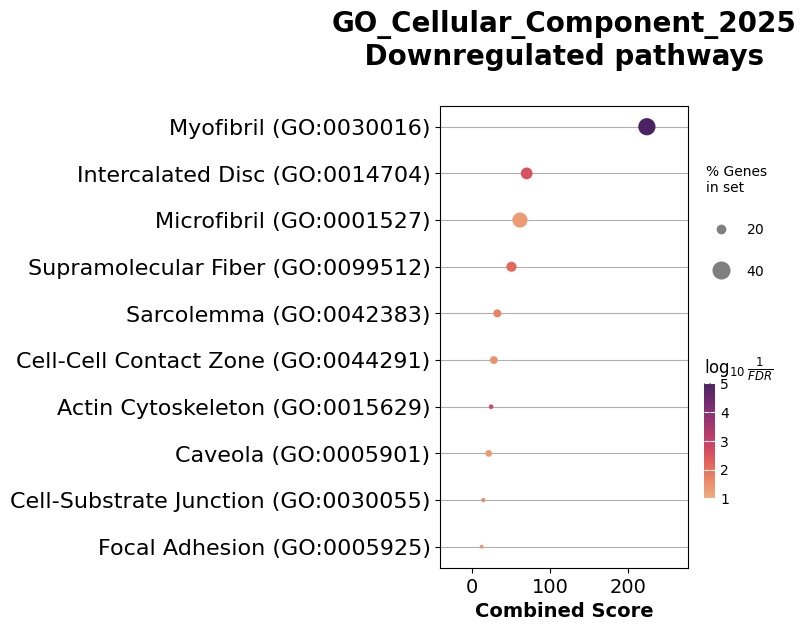

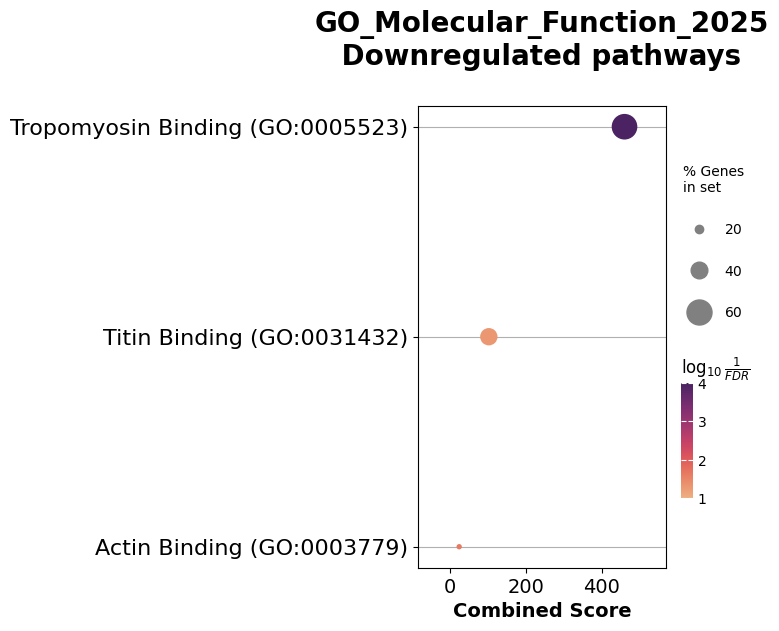

In [71]:


for k, v in go_dwr_results_dau.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k}\n Downregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")



In [67]:
go_upr_results_gef = {}
go_dwr_results_gef = {}

for db in GO_databases:
    try:
        print(f"    {db}")

        # Upregulated genes
        enr_upr = gseapy.enrichr(
            gene_list=upregulated_genes_gef.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_upr_results_gef[db] = enr_upr.res2d

        # Downregulated genes
        enr_dwr = gseapy.enrichr(
            gene_list=downregulated_genes_gef.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_dwr_results_gef[db] = enr_dwr.res2d

    except Exception as e:
        time.sleep(30)  # Wait longer if there's an error


    GO_Biological_Process_2025
    GO_Cellular_Component_2025
    GO_Molecular_Function_2025


In [68]:
print(go_upr_results_gef)
print(go_dwr_results_gef)

{}
{}


In [69]:
for k, v in go_upr_results_gef.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k[0], k[1]} \n {k[2]} \n Upregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                # top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")



In [70]:
for k, v in go_dwr_results_gef.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k[0], k[1]} \n {k[2]} \n Upregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                # top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")

**Solution**  
- For **Daunorubicin** treatment, there are no enriched pathways for upregulated genes, but there are downregulated pathways related to cardiac development, cardiac contraction and development of myofibrils (actin, myosin and titin).
- Daunorubicin likely causes cardiotoxicity by disrupting the interaction between actin and myosin within the myofibrils, therefore reducing the contractability of the cardiomyocites.

- Since there are few DE genes for **Gefinitib**, the GO analysis returns no results. Gefinitib is likely not toxic to cardiomyocites.



Literature:
- Daunorubicin leads to myofibril degradation
https://www.oatext.com/cardiotoxicity-induced-by-antineoplastic-drug-daunorubicin-and-its-amelioration-a-review-of-literature.php
- Daunorubicin interacts with myosin https://link.springer.com/article/10.1007/s12011-008-8201-0